In [ ]:
import sentencepiece as spm
import os 
import torch
from  datasets import  load_dataset
from datasets.dataset_dict import DatasetDict
from datasets import Dataset 
from tokenizers import ByteLevelBPETokenizer
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, ByteLevelBPETokenizer, models, pre_tokenizers, normalizers, Regex, decoders,  processors

: 

In [2]:
DEVICE = torch.device("cuda:0")

In [4]:
tokenizer = ByteLevelBPETokenizer(add_prefix_space=True)
tokenizer.normalizer = normalizers.Sequence([
    normalizers.NFKC(),
    normalizers.Replace(Regex(" {2,}"), " "),
    normalizers.Strip()
])
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.Metaspace(),
    pre_tokenizers.Digits(individual_digits=True),
    pre_tokenizers.Punctuation(behavior='isolated'),
    pre_tokenizers.Split(pattern="\n", behavior="isolated")
])
tokenizer.decoder = decoders.Metaspace()

special_tokens = ["<pad>", "<unk>", "<s>", "</s>", "<sep>"]
trainer = tokenizer.train(
    files = 'wiki-sentences.txt',
    vocab_size=400,
    special_tokens=special_tokens,
    )

bos_token_id = tokenizer.token_to_id("<s>")
eos_token_id = tokenizer.token_to_id("</s>")
sep_token_id = tokenizer.token_to_id("<sep>")
tokenizer.post_processor = processors.TemplateProcessing(
    single="<s>:0 $A:0 </s>:0",
     pair="<s>:0 $A:0 <sep>:0 $B:1 </s>:1",
    special_tokens=[("<sep>", sep_token_id), ("<s>", bos_token_id), ("</s>", eos_token_id)],
    )
wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token="<s>",
        eos_token="</s>",
        unk_token="<unk>",
        pad_token="<pad>",
        sep_token="<sep>",
        padding_side="left",
    )
wrapped_tokenizer.save_pretrained('tok_jp')

('tok_jp\\tokenizer_config.json',
 'tok_jp\\special_tokens_map.json',
 'tok_jp\\tokenizer.json')

In [3]:
dataset = load_dataset("wikimedia/wikisource", "20231201.ja")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 11879
    })
})

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("tok_jp")

In [6]:
dataset = Dataset.from_dict({
    'text': dataset["train"]['text'],
})

dataset_dict = DatasetDict({
    'train': dataset.train_test_split(test_size=0.2)['train'],
    'test': dataset.train_test_split(test_size=0.2)['test']
})

In [7]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True , padding = True , max_length = 128)

In [8]:
tokenized_sent = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/9503 [00:00<?, ? examples/s]

Map:   0%|          | 0/2376 [00:00<?, ? examples/s]

In [9]:
tokenized_sent

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9503
    })
    test: Dataset({
        features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2376
    })
})

In [11]:
from einops import rearrange, repeat
import torch
from torch import nn, Tensor

class DecoderBlock(torch.nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor ):
        
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)
     

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm (x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(torch.nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor ):
        batch_size, context_len = inputs.shape
        

        token_embedding = self.token_embeddings(inputs)

        positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b = batch_size)
        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding
        embedding = rearrange(embedding, 'b s d -> s b d')
        

        return self.model(embedding)





In [12]:
def evaluate(model, val_loader, device, epoch):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()

    correct = 0
    loss = 0.

    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch
        with torch.no_grad():
            output = model(inputs)[-1,:,:]
            correct += (torch.argmax(output, dim=1) == labels).sum()
            loss += criterion(output, labels) * len(labels)

    acc = correct / len(val_loader.dataset)
    loss = loss / len(val_loader.dataset)

    metrics = {
        "accuracy": acc.item(),
        "loss": loss.item(),
    }

    return metrics

In [13]:
model = Transformer(
    num_layers=2,
    dim_model=128,
    num_heads=8,
    num_tokens=tokenizer.vocab_size,
    seq_len=128
    ).to(DEVICE)

In [14]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.97),
    eps=1e-5,
    weight_decay=1
    )
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor = 0.1, total_iters=9
)
criterion = torch.nn.CrossEntropyLoss()

In [24]:
num_epochs = 100

In [16]:
from torch.utils.data import DataLoader, Dataset

In [17]:
class TextDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return torch.tensor(item['input_ids'])

In [18]:
train_dataset = TextDataset(tokenized_sent['train'])
test_dataset = TextDataset(tokenized_sent['test'])

In [22]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [29]:
losses = []

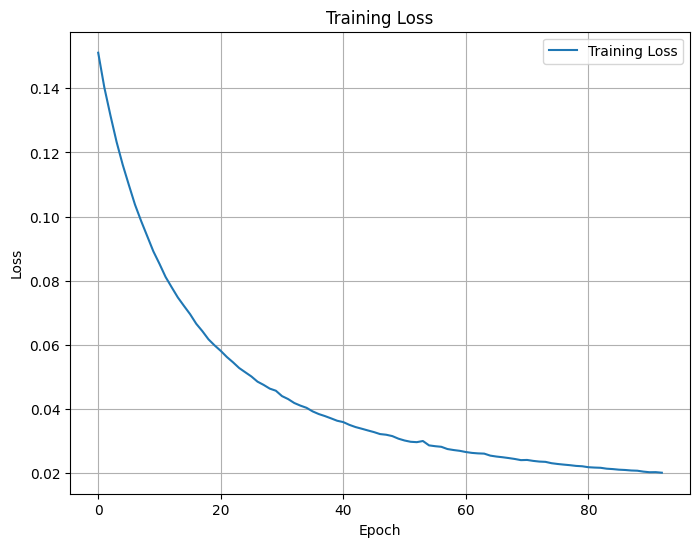

Epoch 94/100, Loss: 0.019895009808242322


KeyboardInterrupt: 

In [30]:
for  epoch in  range(num_epochs):
    model.train()
    total_loss= 0
    for batch in train_loader:
        batch_inputs = batch.to(DEVICE)
        

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        outputs = outputs.permute(1, 2, 0)  # [seq_len, batch_size, vocab_size] -> [batch_size, vocab_size, seq_len] # [batch_size, seq_len] -> [seq_len, batch_size]

        loss = criterion(outputs, batch_inputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
    losses.append(avg_loss) 


    if epoch % 2 == 0:
        clear_output(True)  
        plt.figure(figsize=(8, 6))  
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(losses, label="Training Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
   


        
    